### Ideen zur Analyse:
- [ ] xGoals-Modell
- [ ] xGoalsConceded-Modell
- [ ] Tabelle am Ende der Saison basierend auf xGoals
- [ ] Torquote von Schüssen je nachdem wohin (Elfmeter, Freistösse, aus dem Spiel)

to be continued...

### Ideen zur Feature-Creation:
Event:
- [x] Passlänge
- [x] Passwinkel zum Tor (kann z.B. in horizontal, diagonal und vertikal (jeweils vor- und rückwärts) kategorisiert werden)
- [x] Aktion erstes/zweites/drittes Drittel
- [x] 0-1-Flags für bestimmte Tags: 
- [x] Aktion Flügel/Halbfeld/Zentrum
- [x] vorangegangene Aktion
- [x] falls vorangegangene Aktion Vorlage zu Schuss: Art des Passes, Passlänge etc.
- [x] Schuss/Pass mit starkem/schwachen Fuss (oder Kopf/Körper) mit Hilfe von Spielerverzeichnis (da gibt es den starken Fuss pro Spieler)
- [x] Position des Spielers

to be continued...

Spieler:
- [ ] Pass-/Schussgenauigkeit (je Drittel/Richtung/Distanz/starker oder schwacher Fuss)
- [ ] Anteil horizontale/diagonale/vertikale Pässe
- [ ] Torgefar (Tore pro Schuss)

Themen anschauen:
- Handling imbalanced datasets
    - [ ] Over/undersampling/SMOTE
- [ ] Interpretation Odds/Odds-ratio/probability

to be continued...

### Todos:
- [ ] Zusammenhang zwischen zwei beliebigen Features visualisieren (per scatterplot, boxplot oder ähnlich)
- [ ] Grafiken schön machen (Titel, Achsentitel, Beschreibung etc.)
- [ ] Vorgehen mit Freistössen und Elfmetern (sind separat und nicht als Schüsse hinterlegt) überlegen
- [ ] pre- vs. post-shot-xGoals berechnen

## Import of data and libraries

In [5]:
from itertools import chain, product
import json
import math
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import is_bool_dtype, is_numeric_dtype
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

Import the events from Bundesliga in Germany for exploration. Later on, the other leagues should be considered as well.

In [6]:
dfs_events = {}
dfs_matches = {}
events = {}
matches = {}

competitions = ['england', 'european_championship', 'france', 'germany', 'italy', 'spain', 'world_cup']

for competition in competitions:
    with open(f'data/events/events_{competition}.json') as json_file:
        events[competition] = json.load(json_file)
        dfs_events[competition] = pd.DataFrame(events[competition])
        dfs_events[competition]['competition'] = competition
        print(f'{competition}: {dfs_events[competition].shape[0]} events loaded.')

    with open(f'data/matches/matches_{competition}.json') as json_file:
        matches[competition] = json.load(json_file)
        dfs_matches[competition] = pd.DataFrame(matches[competition])
        dfs_matches[competition]['competition'] = competition
        print(f'{competition}: {dfs_matches[competition].shape[0]} matches loaded.')

df_events = pd.concat([pd.DataFrame(dfs_events[competition]) for competition in competitions]).reset_index()
df_matches = pd.concat([pd.DataFrame(dfs_matches[competition]) for competition in competitions])
df_matches.set_index('wyId', inplace = True)

england: 643150 events loaded.
england: 380 matches loaded.
european_championship: 78140 events loaded.
european_championship: 51 matches loaded.
france: 632807 events loaded.
france: 380 matches loaded.
germany: 519407 events loaded.
germany: 306 matches loaded.
italy: 647372 events loaded.
italy: 380 matches loaded.
spain: 628659 events loaded.
spain: 380 matches loaded.
world_cup: 101759 events loaded.
world_cup: 64 matches loaded.


In [7]:
df_tag_labels = pd.read_csv('data/mappings/tags2name.csv')
df_tag_labels.set_index('Tag', inplace = True)

In [8]:
df_event_labels = pd.read_csv('data/mappings/eventid2name.csv')

In [9]:
with open('data/players.json') as json_file:
    players = json.load(json_file)

df_players = pd.json_normalize(players)
df_players.set_index('wyId', inplace = True)

In [10]:
with open('data/teams.json') as json_file:
    teams = json.load(json_file)

df_teams = pd.json_normalize(teams)
df_teams.set_index('wyId', inplace = True)

## Assets and constants

In [11]:
img_full_pitch = mpimg.imread('assets/football_pitch.png')
img_half_pitch = mpimg.imread('assets/football_pitch_half.png')

PITCH_LENGTH, PITCH_WIDTH, GOAL_WIDTH = 100, 65, 7.32

## General Cleaning

For some events, the playerId is 0 and therefore cannot be matched with a player from the database. Let's drop those entries (mainly interruption-events).

In [12]:
missing_player_id = df_events[df_events['playerId'] == 0].index
df_events.drop(missing_player_id, inplace = True)
print(f'{len(missing_player_id)} events with unrecorded playerId removed.')

226038 events with unrecorded playerId removed.


## Feature creation

Simplify the 'tags'-column by flattening and unpacking the dictionaries to a list.

In [13]:
df_events['tags'] = df_events['tags'].apply(lambda x: list(chain.from_iterable(d.values() for d in x)))

Split up the 'positions'-column for easier access.

In [14]:
df_events['xPosStart'] = df_events['positions'].apply(lambda x: x[0]['x'])
df_events['yPosStart'] = df_events['positions'].apply(lambda x: x[0]['y'])
df_events['xPosEnd'] = df_events['positions'].apply(lambda x: x[1]['x'] if len(x) == 2 else x[0]['x'])
df_events['yPosEnd'] = df_events['positions'].apply(lambda x: x[1]['y'] if len(x) == 2 else x[0]['y'])
df_events.drop(columns = ['positions'], inplace = True)

Calculate distance between start- and end-position assuming the pitch has a standard length of 100m and a standard width of 65m.

In [15]:
df_events['distance'] = df_events.apply(
    lambda row: np.linalg.norm(((row['xPosEnd'] - row['xPosStart']) * PITCH_LENGTH / 100, (row['yPosEnd'] - row['yPosStart']) * PITCH_WIDTH / 100)), 
    axis = 1
    )

There are some events in the dataframe with 0m distance (maybe they were too short to have differing start- and end-position.) Let's drop them, as they would cause problems when calculating passing-angles.

In [16]:
passes_with_zero_distance = df_events[df_events['distance'] == 0].index
df_events.drop(passes_with_zero_distance, inplace = True)
print(f'{len(passes_with_zero_distance)} passes with zero distance removed.')

10359 passes with zero distance removed.


Calulate distance to goal (closest point) before and after the event.

In [17]:
y_min_goal = 50 - (GOAL_WIDTH / (PITCH_WIDTH * 2) * 100)
y_max_goal = 50 + (GOAL_WIDTH / (PITCH_WIDTH * 2) * 100)

def y_closest_goal(y):
    if y < y_min_goal:
        y_closest = y_min_goal
    elif y > y_max_goal:
        y_closest = y_max_goal
    else:
        y_closest = y
    return y_closest

def distance_to_goal(x, y):
    vector_to_goal = ((100 - x) * PITCH_LENGTH / 100, (y_closest_goal(y) - y) * PITCH_WIDTH / 100)
    distance_closest = np.linalg.norm(vector_to_goal)
    return distance_closest

In [18]:
df_events['goalDistanceStart'] = df_events.apply(lambda row: distance_to_goal(row['xPosStart'], row['yPosStart']), axis = 1)
df_events['goalDistanceEnd'] = df_events.apply(lambda row: distance_to_goal(row['xPosEnd'], row['yPosEnd']), axis = 1)
df_events['goalDistanceCovered'] = df_events['goalDistanceEnd'] - df_events['goalDistanceStart']

Calculate the angle between the line between the start- and end-position and a vertical line.

In [19]:
def angle(u, v):
    dot_prod = np.dot(u, v)
    u_norm = np.linalg.norm(u)
    v_norm = np.linalg.norm(v)
    return math.degrees(math.acos(dot_prod / (u_norm * v_norm)))

In [20]:
df_events['angle'] = df_events.apply(
    lambda row: angle(((row['xPosEnd'] - row['xPosStart']) * PITCH_LENGTH / 100, (row['yPosEnd'] - row['yPosStart']) * PITCH_WIDTH / 100), (1, 0)), 
    axis = 1
    )

Categorize angles as vertical forward/backward or horizontal

In [21]:
bins = [0, 22.5, 67.5, 112.5, 157.5, 180]

labels = ['vertical forward', 'diagonal forward', 'horizontal', 'diagonal backward', 'vertical backward']

df_events['angleCategory'] = pd.cut(df_events['angle'], bins = bins, labels = labels, include_lowest = True, ordered = False)



Calculate angle to goal before and after the event. We will do this by calculating the angle of the vector from the event's position to the closest point of the goal.

In [22]:
def angle_to_goal(x, y):
    vector_to_goal = ((100 - x) * PITCH_LENGTH / 100, (y_closest_goal(y) - y) * PITCH_WIDTH / 100)
    if vector_to_goal == (0, 0):
        angle_closest = 0
    else:
        angle_closest = angle(vector_to_goal, (1, 0))
    return angle_closest

In [23]:
df_events['goalAngleStart'] = df_events.apply(lambda row: angle_to_goal(row['xPosStart'], row['yPosStart']), axis = 1)
df_events['goalAngleEnd'] = df_events.apply(lambda row: angle_to_goal(row['xPosEnd'], row['yPosEnd']), axis = 1)

If applicable extract the information with which bodypart the event was carried out and if it was the strong/weak foot.

In [24]:
def label_bodyPart(tags, strong_foot):
    relevant_tags = [401, 402, 403]
    filtered_tags = list(set(tags) & set(relevant_tags))
    if len(filtered_tags) > 0:
        bodyPart = df_tag_labels.loc[filtered_tags[0], 'Label'].lower()
        if bodyPart == 'head/body':
            label = bodyPart
        elif bodyPart == strong_foot:
            label = 'strong foot'
        else:
            label = 'weak foot'
    else:
        label = 'unknown'
    return label

In [25]:
df_events['bodyPart'] = df_events.apply(lambda row: label_bodyPart(row['tags'], df_players.loc[row['playerId'], 'foot']), axis = 1)

Extract the role the player plays in (goalkeeper, defender, midfielder or forward) of each event as that could also effect the probability of a shot being converted into a goal.

In [26]:
df_events['playerRole'] = df_events.apply(lambda row: df_players.loc[row['playerId'], 'role.code3'], axis = 1)

If applicable extract the information with which part of the goal the shot was aimed at.

In [27]:
def label_tags(tags, relevant_tags):
    filtered_tags = list(set(tags) & set(relevant_tags))
    if len(filtered_tags) > 0:
        label = df_tag_labels.loc[filtered_tags[0], 'Label'].lower()
    else:
        label = 'unknown'
    return label

In [28]:
df_events['aimedGoalPart'] = df_events['tags'].apply(lambda x: label_tags(x, list(range(1201, 1224))))

Create some more tag-flags

In [29]:
df_events['keyPass'] = df_events['tags'].apply(lambda x: 302 in x)
df_events['dangerousBallLost'] = df_events['tags'].apply(lambda x: 2001 in x)
df_events['opportunity'] = df_events['tags'].apply(lambda x: 201 in x)
df_events['counterAttack'] = df_events['tags'].apply(lambda x: 1901 in x)
df_events['through'] = df_events['tags'].apply(lambda x: 901 in x)
df_events['high'] = df_events['tags'].apply(lambda x: 801 in x)
df_events['accurate'] = df_events['tags'].apply(lambda x: True if 1801 in x else False if 1802 in x else None)
df_events['goal'] = df_events['tags'].apply(lambda x: 101 in x or 102 in x)

For each event provide some information about the previous event. It might be interesting for shot-analysis later on to see the effect of the type of the preceding event (e.g. high/low pass or dribble) on the shot's outcome. For simpliciyt we just shift the columns of interest by one and handle the edge cases (each match-half's first and last event) afterwards.

In [30]:
cols_shift = ['eventId', 'eventName', 'subEventId', 'subEventName', 'distance', 'angle', 'angleCategory', 'dangerousBallLost', 'keyPass', 'through', 'high']
df_events[[f'prev{col[0].capitalize()}{col[1:]}' for col in cols_shift]] = df_events[cols_shift].shift(1)

## Pass analysis

Plot all of a player's passes in a game.

In [31]:
pass_line_colors = {
    'vertical forward': 'green',
    'vertical backward': 'red',
    'diagonal forward': 'blue',
    'diagonal backward': 'orange',
    'horizontal': 'grey'
}

def plot_passes(feature = 'angleCategory', matchId = None, playerId = None):
    df_player_passes = df_events[(df_events['matchId'] == matchId) & (df_events['eventName'] == 'Pass')].copy()
    if playerId:
        df_player_passes = df_player_passes[(df_player_passes['playerId'] == playerId)]
    unique_values = df_player_passes[feature].unique()
    colors = plt.cm.get_cmap('tab10', len(unique_values)).colors
    color_map = dict(zip(unique_values, [mcolors.rgb2hex(c) for c in colors]))
    for i in df_player_passes.index:
        if feature == 'angleCategory':
            color = pass_line_colors[df_player_passes.loc[i, 'angleCategory']]
        else:
            color = color_map.get(df_player_passes.loc[i, feature])

        if 1801 in df_player_passes.loc[i, 'tags']:
            linestyle = 'solid'
        else:
            linestyle = 'dotted'
        x = [df_player_passes.loc[i, 'xPosStart'] * PITCH_LENGTH / 100, df_player_passes.loc[i, 'xPosEnd'] * PITCH_LENGTH / 100]
        y = [(100 - df_player_passes.loc[i, 'yPosStart']) * PITCH_WIDTH / 100, (100 - df_player_passes.loc[i, 'yPosEnd']) * PITCH_WIDTH / 100]

        plt.plot(x, y, color = color, linestyle = linestyle)
        plt.scatter(df_player_passes.loc[i, 'xPosStart'] * PITCH_LENGTH / 100, (100 - df_player_passes.loc[i, 'yPosStart']) * PITCH_WIDTH / 100, marker = 'o', color = color)
        plt.scatter(df_player_passes.loc[i, 'xPosEnd'] * PITCH_LENGTH / 100, (100 - df_player_passes.loc[i, 'yPosEnd']) * PITCH_WIDTH / 100, marker = 'x', color = color)
    plt.imshow(img_full_pitch, extent=[0, 100, 0, 65], aspect='auto')
    if playerId:
        player_name = df_players.loc[playerId, 'shortName']
        plt.title(f'Pässe von {player_name} in Match {matchId}')
    else:
        plt.title(f'Pässe in Match {matchId}')
    plt.xlim(0, 100)
    plt.ylim(0, 65)
    plt.axis('off')
    return None

In [32]:
def plot_passing_stats(matchId, playerId):
    if matchId:
        df_player_passes = df_events[(df_events['playerId'] == playerId) & (df_events['matchId'] == matchId) & (df_events['eventName'] == 'Pass')].copy()
    else:
        df_player_passes = df_events[(df_events['playerId'] == playerId) & (df_events['eventName'] == 'Pass')].copy()

    direction_shares_accurate = df_player_passes[df_player_passes['accurate']].groupby('angleCategory')['id'].count()/df_player_passes.shape[0]
    direction_shares_inaccurate = df_player_passes[df_player_passes['accurate'].apply(lambda x: not x)].groupby('angleCategory')['id'].count()/df_player_passes.shape[0]
    
    direction_shares_accurate = direction_shares_accurate.reindex(['vertical backward', 'diagonal backward', 'horizontal', 'diagonal forward', 'vertical forward'])
    direction_shares_inaccurate = direction_shares_inaccurate.reindex(['vertical backward', 'diagonal backward', 'horizontal', 'diagonal forward', 'vertical forward'])
    
    plt.bar(x = direction_shares_accurate.index, height = direction_shares_accurate)
    plt.bar(x = direction_shares_accurate.index, height = direction_shares_inaccurate, bottom = direction_shares_accurate)
    
    player_name = df_players.loc[playerId, 'shortName']
    plt.title(f'Pässe von {player_name} in Match {matchId}')
    plt.xticks(rotation=90)

    for i, values in enumerate(zip(direction_shares_accurate, direction_shares_inaccurate)):
        plt.annotate(f'{values[0] * 100:.2f}%',
            (i, values[0] / 2),
            ha='center',
            va = 'center')
        plt.annotate(f'{values[1] * 100:.2f}%',
            (i, values[0] + (values[1] / 2)),
            ha='center',
            va = 'center')
        plt.annotate(f'∑ {(values[0] + values[1]) * 100:.2f}%',
            (i, values[0] + values[1] + 0.01),
            ha='center',
            va = 'center',
            fontweight = 'bold')
    return None

C:\Users\4330\AppData\Local\Temp\ipykernel_8092\742343089.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  direction_shares_accurate = df_player_passes[df_player_passes['accurate']].groupby('angleCategory')['id'].count()/df_player_passes.shape[0]
C:\Users\4330\AppData\Local\Temp\ipykernel_8092\742343089.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  direction_shares_inaccurate = df_player_passes[df_player_passes['accurate'].apply(lambda x: not x)].groupby('angleCategory')['id'].count()/df_player_passes.shape[0]


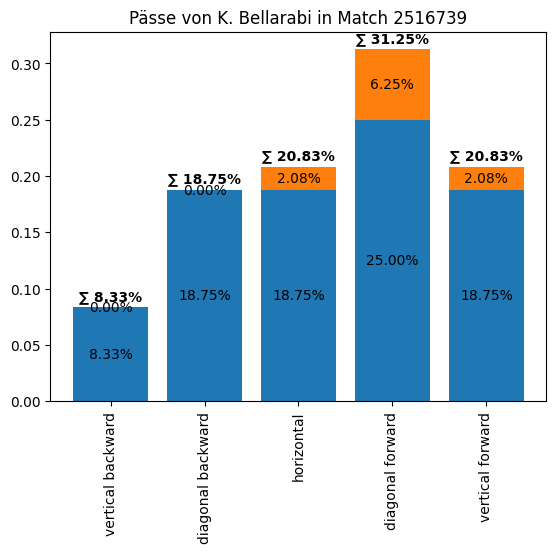

In [33]:
plot_passing_stats(2516739, 14786)

C:\Users\4330\AppData\Local\Temp\ipykernel_8092\2960129647.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_values)).colors


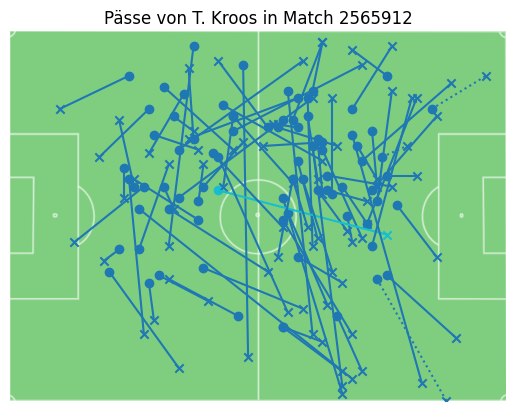

In [34]:
plot_passes('keyPass', 2565912, 14723)

## Shot-analysis

Now we want to perform a logistic-regression on all of the shots in df_events in order to predict the goal-probability by position, angle, bodypart, previous event and so on.
To do so, we first create a new dataframe with only the shots.

In [35]:
df_shots = df_events[df_events['eventName'] == 'Shot'].copy()

Let's first visualize each of the feature's correlation to a shot's outcome.

In [36]:
def plot_shots(feature, showMisses = True, matchId = None, teamId = None, playerId = None):
    
    df_relevant_shots = df_shots.copy()
    for key, value in {'matchId': matchId, 'teamId': teamId, 'playerId': playerId}.items():
        if value:
            df_relevant_shots = df_relevant_shots[df_relevant_shots[key] == value].copy()

    if showMisses:
        df_misses = df_relevant_shots[~df_relevant_shots['goal']].copy()
    df_goals = df_relevant_shots[df_relevant_shots['goal']].copy()

    plt.imshow(img_half_pitch, extent = [50, 100, 0, 100], aspect = 0.5 * PITCH_LENGTH / PITCH_WIDTH)
    plt.axis('off')

    unit_name = df_players.loc[playerId, 'shortName'] if playerId else (df_teams.loc[teamId, 'name'] if teamId else None)
    unit_name = f'von {unit_name}' if unit_name else ''
    
    #plt.title(f'{'Schüsse' if showMisses else 'Tore'} {unit_name} in Match {matchId}')

    if is_numeric_dtype(df_relevant_shots[feature]):
        vmin, vmax = df_relevant_shots[feature].min(), df_relevant_shots[feature].max()
        if showMisses:
            plt.scatter(x = 'xPosStart', y = 'yPosStart', data = df_misses, c = df_misses[feature], cmap = 'inferno', vmin = vmin, vmax = vmax, marker = 'o')
            plt.colorbar(label = feature)
        plt.scatter(x = 'xPosStart', y = 'yPosStart', data = df_goals, c = df_goals[feature], cmap = 'inferno', vmin = vmin, vmax = vmax, marker = 'x')
        if not showMisses:
            plt.colorbar(label = feature)
    else:
        categories = df_relevant_shots[feature].unique()
        color_map = {category: plt.cm.tab10(i) for i, category in enumerate(categories)}
        if showMisses:
            for category, color in color_map.items():
                subset = df_misses[df_misses[feature] == category]
                plt.scatter(x = 'xPosStart', y = 'yPosStart', data = subset, label = category,  color = color, marker = 'o')
            plt.legend(title = feature, loc = 'upper left')
        for category, color in color_map.items():
            subset = df_goals[df_goals[feature] == category]
            plt.scatter(x = 'xPosStart', y = 'yPosStart', data = subset, label = category, color = color, marker = 'x')
        if not showMisses:
            plt.legend(title = feature, loc = 'upper left')


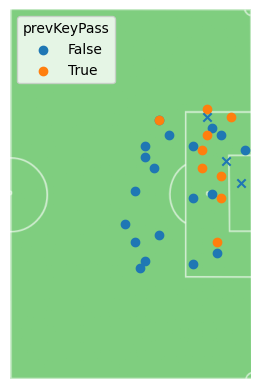

In [37]:
plot_shots('prevKeyPass', True, 2516739)

Helper-function to define bins and labels for a desired number of bins.

In [38]:
def n_bins_labels(series, bin_count, equal_bin_sizes):
    if equal_bin_sizes:
        bins = [np.percentile(series, i / bin_count * 100) for i in range(bin_count + 1)]
    else:
        bins = [series.min() + (series.max() - series.min()) * i / bin_count for i in range(bin_count + 1)]
    labels = [f'{bins[i - 1]:.2f} - {bins[i]:.2f}' for i in range(1, len(bins))]
    return bins, labels

In [39]:
def feature_goal_corr_bars(feature, bin_count = 5, equal_bin_sizes = True):

    df = df_shots.copy()

    if is_numeric_dtype(df[feature]):
        bins, labels = n_bins_labels(df[feature], bin_count, equal_bin_sizes)
        df[f'{feature}Bins'] = pd.cut(df[feature], bins = bins, labels = labels, right = True, include_lowest = True)
        feature_counts = df[f'{feature}Bins'].value_counts()
        goal_shares = df.groupby(f'{feature}Bins')['goal'].mean()
    else:
        feature_counts = df[feature].value_counts()
        goal_shares = df.groupby(feature)['goal'].mean()
        if not is_bool_dtype(df[feature]):
            goal_shares.sort_values(ascending = False, inplace = True)
            feature_counts = feature_counts.loc[goal_shares.index]
    
    bars = plt.bar(x = goal_shares.index, height = goal_shares)

    for bar, count in zip(bars, feature_counts):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height() / 2
        annotation = f'{y * 2 * 100:.2f}%\n(out of {count})'
        plt.annotate(annotation, (x, y), ha='center', va = 'center')
    
    plt.xticks(rotation = 45, ha = 'right')
    plt.title(feature)
    return None

In [40]:
def two_features_goal_corr_bars(feature_1, feature_2, bin_count_1 = 5, bin_count_2 = 5, equal_bin_sizes_1 = False, equal_bin_sizes_2 = False):

    df = df_shots.copy()

    feature_names = {}
    categories = {}
    
    for feature, bin_count, equal_bin_sizes in zip([feature_1, feature_2], [bin_count_1, bin_count_2], [equal_bin_sizes_1, equal_bin_sizes_2]):
        if is_numeric_dtype(df[feature]):
            bins, labels = n_bins_labels(df[feature], bin_count, equal_bin_sizes)
            df[f'{feature}Bins'] = pd.cut(df[feature], bins = bins, labels = labels, right = True, include_lowest = True)
            feature_names[feature] = f'{feature}Bins'
            categories[feature] = labels
        else:
            feature_names[feature] = feature
            categories[feature] = df[f'{feature}'].unique()

    
    goal_share_matrix = [
            [val_1, val_2, df[(df[feature_names[feature_1]] == val_1) & (df[feature_names[feature_2]] == val_2)]['goal'].mean()]
                for val_1, val_2 in product(categories[feature_1], categories[feature_2])
        ]
    
    df_goal_shares = pd.DataFrame(goal_share_matrix, columns = [feature_1, feature_2, 'goal_share']).dropna()

    ax = sns.barplot(data = df_goal_shares, x = feature_1, y = 'goal_share', hue = feature_2)
    ax.set_xticklabels(labels = categories[feature_1], rotation = 45, ha = 'right')

    return None

C:\Users\4330\AppData\Local\Temp\ipykernel_8092\1709938972.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = categories[feature_1], rotation = 45, ha = 'right')


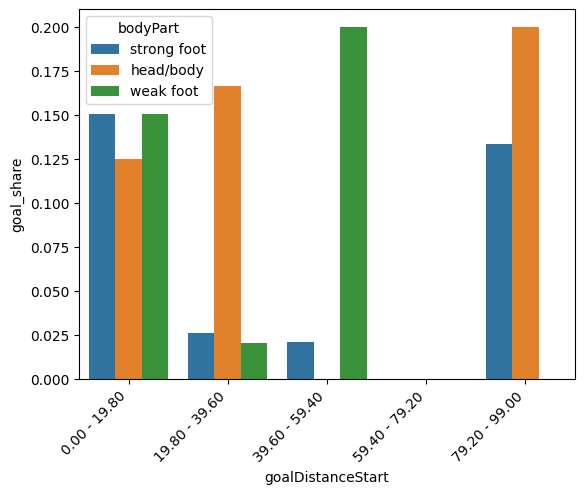

In [41]:
two_features_goal_corr_bars('goalDistanceStart', 'bodyPart')

In [42]:
def category_heatmap(feature_1, feature_2, bin_count_1 = 5, bin_count_2 = 5, equal_bin_sizes_1 = False, equal_bin_sizes_2 = False):

    df = df_shots.copy()

    feature_names = {}
    categories = {}
    
    for feature, bin_count, equal_bin_sizes in zip([feature_1, feature_2], [bin_count_1, bin_count_2], [equal_bin_sizes_1, equal_bin_sizes_2]):
        if is_numeric_dtype(df[feature]):
            bins, labels = n_bins_labels(df[feature], bin_count, equal_bin_sizes)
            df[f'{feature}Bins'] = pd.cut(df[feature], bins = bins, labels = labels, right = True, include_lowest = True)
            feature_names[feature] = f'{feature}Bins'
            categories[feature] = labels
        else:
            feature_names[feature] = feature
            categories[feature] = df[f'{feature}'].unique()

    share_matrix = [
        [
            df[(df[feature_names[feature_1]] == val_1) & (df[feature_names[feature_2]] == val_2)].shape[0] / df.shape[0] * 100
            for val_1 in categories[feature_1]
            ] 
        for val_2 in categories[feature_2]
        ]
    
    share_matrix = pd.DataFrame(share_matrix).dropna()

    annot = [[f'{share_matrix.iloc[i, j]:.2f}%' for j in range(share_matrix.shape[1])] for i in range(share_matrix.shape[0])]

    ax = sns.heatmap(
        data = share_matrix,
        annot = annot, 
        cbar = True,
        cmap = 'coolwarm', 
        fmt = '',
        square = True
        )

    ax.set_xticklabels(categories[feature_1], rotation = 45, ha = 'right')
    ax.set_yticklabels(categories[feature_2], rotation = 0)
    ax.set_xlabel(feature_1)
    ax.set_ylabel(feature_2)
    ax.set_title(f'Anteil Schüsse nach {feature_1} und {feature_2}')
    return None

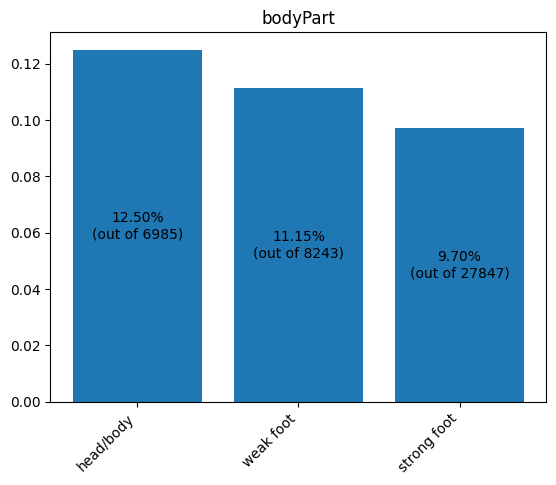

In [43]:
feature_goal_corr_bars('bodyPart', 5, False)

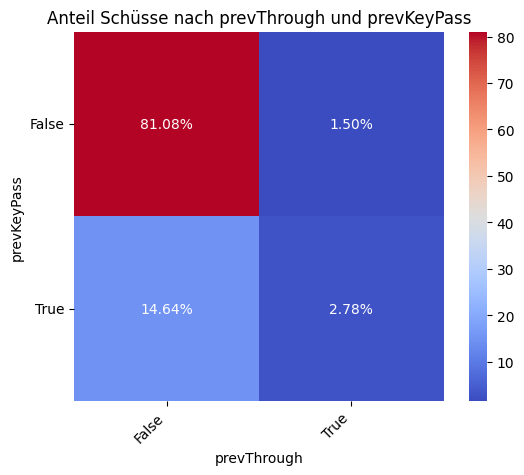

In [44]:
category_heatmap('prevThrough', 'prevKeyPass', 3, 4)

## Handling Outliers

Before tuning and training the model, let's look for outliers that could negatively effect the model's performance. We will do this considering the columns 'xPosStart', 'yPosStart', 'goalDistanceStart', 'bodyPart', and 'playerRole'.

As there are very few (only 7) shots taken from goalkeepers, we will drop them, the sample size is just too small to deduct anything meaningful from it.

In [45]:
df_shots_goalkeeper = df_shots[df_shots['playerRole'] == 'GKP']
df_shots.drop(df_shots_goalkeeper.index, inplace = True)
print(f'Dropped {df_shots_goalkeeper.shape[0]} shots taken by goalkeepers')

Dropped 7 shots taken by goalkeepers


As seen in below histogram, there are very few shots taken from a distance greater than 40 meters. As those shots are only interesting when we know the goalkeeper's position (and as we also see below none of those shots is preceded by the event 'Goalkeeper leaving line' so we have no information about the goalkeeper's position). So for a better general model-performance we will drop all of the shots taken from very far out (> 40m).

In [46]:
df_shots[df_shots['prevEventName'] == 'Goalkeeper leaving line']['goalDistanceStart'].max()

np.float64(33.62641967263241)

(array([9.0530e+03, 1.9469e+04, 1.2422e+04, 1.9130e+03, 9.2000e+01,
        6.5000e+01, 3.0000e+01, 3.0000e+00, 5.0000e+00, 1.6000e+01]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <BarContainer object of 10 artists>)

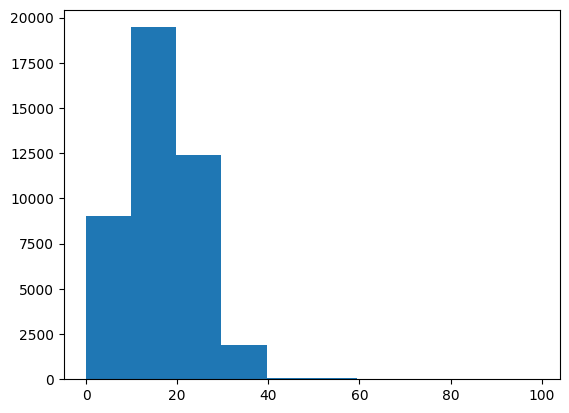

In [47]:
plt.hist(x = df_shots['goalDistanceStart'], bins = 10)

As seen below, some of the shots from far out are even stated headers, so they might just be falsly classified.

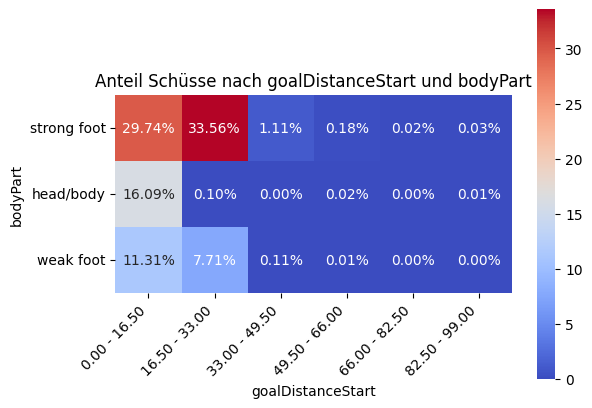

In [48]:
category_heatmap('goalDistanceStart', 'bodyPart', 6, 3)

In [49]:
df_shots_very_far = df_shots[df_shots['goalDistanceStart'] > 40]
df_shots.drop(df_shots_very_far.index, inplace = True)
print(f'Dropped {df_shots_very_far.shape[0]} shots taken from very far out (>40m)')

Dropped 206 shots taken from very far out (>40m)


## xGoal-classification with Logistic Regression

Let's go ahead and create an xGoal-model. We will train and test the model using all of the leagues except the Bundesliga and then apply it on the Bundesliga to do some analysis using the xGoals.

In [50]:
relevant_cols = { 
    'numerical': ['goalDistanceStart', 'goalAngleStart'],
    'boolean': ['prevDangerousBallLost', 'counterAttack', 'prevKeyPass', 'prevThrough', 'prevHigh'],
    'categorical': ['bodyPart', 'prevEventName', 'prevSubEventName', 'playerRole', 'competition']
    }

In [51]:
X = df_shots[relevant_cols['numerical'] + relevant_cols['boolean'] + relevant_cols['categorical']].copy()
y = df_shots['goal'].copy()

df_bundesliga = df_shots[df_shots['competition'] == 'germany'].copy()

X.drop(df_bundesliga.index, inplace = True)
y.drop(df_bundesliga.index, inplace = True)

X.drop(columns = ['competition'], inplace = True)
relevant_cols['categorical'].remove('competition')
df_bundesliga.drop(columns = ['competition'], inplace = True)

In [52]:
ct = ColumnTransformer(
    transformers = [
        ('', OneHotEncoder(drop = 'first'), relevant_cols['categorical'])
    ],
    remainder = 'passthrough'
)

In [53]:
X = ct.fit_transform(X)
columns_transformed = ct.get_feature_names_out()
X = pd.DataFrame(X.toarray(), columns = columns_transformed)

Perform a gridsearch to find the best hyperparameters (may outcomment the big grid to save time)

In [54]:
model = LogisticRegression(random_state = 42)

#param_grid = {
#    'C': np.logspace(-4, 4, 10),
#    'class_weight': ['balanced', None],
#    'max_iter': [100, 250, 500],
#    'penalty': ['l1', 'l2', None],
#    'solver': [ 'liblinear', 'newton-cholesky','saga']
#}
#Best Hyperparameters: {'C': 0.005994842503189409, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

param_grid = {
    'C': [0.005994842503189409],
    'class_weight': ['balanced', None],
    'max_iter': [100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring = 'f1', verbose = 0, n_jobs = -1)

grid_search.fit(X, y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 0.005994842503189409, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy: 0.427767833514881


In [108]:
best_model = grid_search.best_estimator_
best_model.fit(X, y)

LogisticRegression(C=0.005994842503189409, class_weight='balanced',
                   random_state=42, solver='liblinear')

Let's take a look at the fitted models' coefficient to better understand what features are important when predicting a shot's outcome

In [109]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_model.coef_[0]})

feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

feature_importance[['Feature', 'Coefficient']].head(10)

,Feature,Coefficient
42,remainder__prevKeyPass,-2.853185
0,__bodyPart_strong foot,0.574882
7,__prevEventName_Pass,0.552614
43,remainder__prevThrough,0.483515
36,__playerRole_FWD,0.437885
1,__bodyPart_weak foot,0.422268
41,remainder__counterAttack,0.385292
37,__playerRole_MID,0.301781
8,__prevEventName_Save attempt,0.297897
33,__prevSubEventName_Smart pass,0.282590


## Applying the model on the Bundesliga

In [110]:
df_bundesliga_transformed = ct.transform(df_bundesliga)
df_bundesliga_transformed = pd.DataFrame(df_bundesliga_transformed.toarray(), columns = columns_transformed)

In [111]:
y_test = df_shots[df_shots['competition'] == 'germany']['goal']
y_pred = best_model.predict(df_bundesliga_transformed)
y_pred_probability = best_model.predict_proba(df_bundesliga_transformed)[:, 1]

Let's take a look at the fitted model's confusion-matrix. Besides the number of cases in each class, let's also consider the xGoals-average (i.e. how "sure" the model was of the predicted outcome)

In [72]:
def conf_matrix_avg_probability(y_test, y_pred, y_pred_proba):
    
    df = pd.DataFrame({
        'actual': y_test, 
        'predicted': y_pred, 
        'probability': y_pred_proba
    })
    
    df_TN = df[~df['actual'] & ~df['predicted']]
    df_FP = df[~df['actual'] & df['predicted']]
    df_FN = df[df['actual'] & ~df['predicted']]
    df_TP = df[df['actual'] & df['predicted']]
    
    xgoals_avg = [
        [f' / avg xG: {df_TN["probability"].mean():.2f}', f' / avg xG: {df_FP["probability"].mean():.2f}'], 
        [f' / avg xG: {df_FN["probability"].mean():.2f}', f' / avg xG: {df_TP["probability"].mean():.2f}']
        ]
    
    conf_matrix_avg = np.char.add(confusion_matrix(y_test, y_pred).astype(str), xgoals_avg)
    
    print(
        pd.DataFrame(
            conf_matrix_avg, 
            index = ["Actual Negative", "Actual Positive"], 
            columns = ["Predicted Negative", "Predicted Positive"]
        )
    )
    return None

As we can see, the model on average was close to predict the false negatives correctly as positives and the false positives correctly as negatives.

In [112]:
conf_matrix_avg_probability(y_test, y_pred, y_pred_probability)

                  Predicted Negative   Predicted Positive
Actual Negative  4708 / avg xG: 0.24  1408 / avg xG: 0.64
Actual Positive   146 / avg xG: 0.34   597 / avg xG: 0.76


## Goalscorer analysis

Calculate the number of goals scored by each player.

In [60]:
df_goals = df_events[df_events['goal'] & (df_events['eventName'] != 'Save attempt')]
player_goals = df_goals.groupby('playerId').size()
player_goals = player_goals.rename('goalsScored').reset_index()
df_players_bundesliga = df_players_bundesliga.merge(player_goals, left_index = True, right_on = 'playerId', how = 'left')
df_players_bundesliga['goalsScored'] = df_players_bundesliga['goalsScored'].fillna(0).astype(int)

NameError: name 'df_players_bundesliga' is not defined

List the 10 top-goalscorers.

In [ ]:
df_players_bundesliga[['shortName', 'goalsScored']].sort_values(by = 'goalsScored', ascending = False).head(10)

KeyError: "['goalsScored'] not in index"

We will now do the same, but this time we count the expected goals per player throughout the season.